In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import corner
import emcee

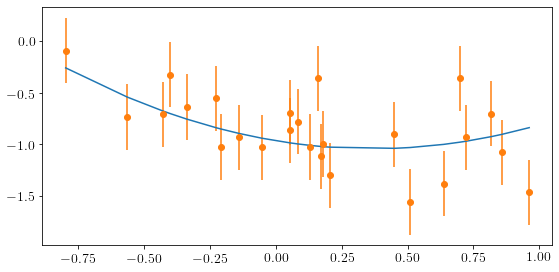

In [17]:
n_datapoints = 25
n_polynomials = 3

# true parameter values
theta_true = np.random.randn(n_polynomials)

# abscissae
xis = np.random.uniform(-1, 1, n_datapoints)
xis.sort() # to simplify plots

# design matrix - contain polynomials
Mis = np.vstack([xis*0+1, xis, xis**2 - 1]).T

# form true ordinate values at abscissae xis
yis_true = np.dot(Mis, theta_true)

# randomly draw noise for the ordinates
yis_var = np.random.uniform(0.1, 0.1, n_datapoints)#(yis_true / 2)**2

# form noisy data
yis = yis_true + yis_var**0.5 * np.random.randn(*yis_var.shape)

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(xis, yis_true)
ax.errorbar(xis, yis, yis_var**0.5, fmt='o')
fig.tight_layout()

In [28]:
log2pi = np.log(2*np.pi)

# log likelihood for diagonal gaussian
def loggaussiandiagvar(ymod, yis, yis_var):
    chi2s = (yis - ymod)**2/yis_var
    ldet = np.log(yis_var)
    cst = yis.size * log2pi
    return - 0.5 * np.sum(chi2s + ldet + log2pi) 

# log likelihood of data given design matrix
def log_like(theta, Mis, yis, yis_var):
    ymod = np.dot(Mis, theta)
    return loggaussiandiagvar(ymod, yis, yis_var)

# unit gaussian prior
def log_prior(theta):
    return loggaussiandiagvar(theta*0, theta, theta*0 + 1)

# log posterior
def log_post(theta, Mis, yis, yis_var):
    return log_like(theta, Mis, yis, yis_var) + log_prior(theta)

print(log_post(theta_true, Mis, yis, yis_var))#, loglike_grad(theta_true)

#loglike_grad = grad(loglike)
#from scipy.optimize import minimize
#minimize(loglike, theta_true)#, jac=loglike_grad)

-8.800025690080416


In [29]:
# analytically compute log evidence as well as best fit parameters and their covariance
def log_evidence(M, y, yvar):
    
    MHiM = np.dot(M.T, M/yvar)
    Meta = np.dot(M.T, y/yvar)
    
    theta_map = np.linalg.solve(MHiM, Meta)
    theta_cov = np.linalg.inv(MHiM)
    
    logdetH = - np.sum(np.log(yvar))
    xi1 = -0.5*(y.size*log2pi - logdetH + np.sum(y*y/yvar))
    
    sMHiM, logdetMHiM = np.linalg.slogdet(MHiM)
    xi2 = -0.5*(Meta.size*log2pi - sMHiM*logdetMHiM + np.dot(Meta.T, theta_map))
    
    logfml = xi1 - xi2
    
    return logfml, theta_map.ravel(), theta_cov

logfml, theta_map, theta_cov = log_evidence(Mis, yis[:, None], yis_var[:, None])

In [30]:
nwalkers = 100
sampler = emcee.EnsembleSampler(nwalkers, npar, log_post, args=[Mis, yis, yis_var])
sampler.run_mcmc(np.random.randn(nwalkers, npar), 1000);

In [33]:
samples= sampler.get_chain(discard=100, thin=15, flat=True)
lnp = sampler.get_log_prob(discard=100, thin=15, flat=True)
print(samples.shape)

(6000, 3)


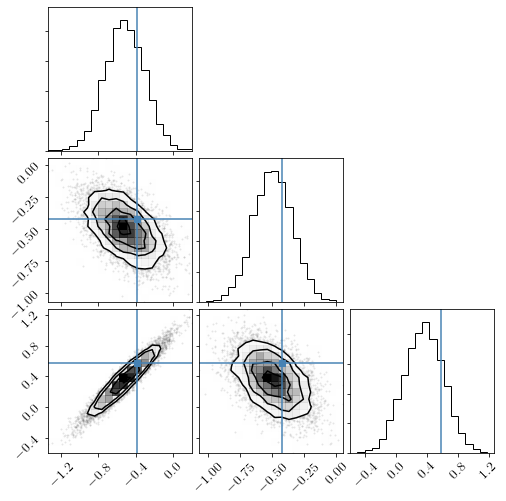

In [34]:
fig = corner.corner(
    samples, truths=theta_true
);

In [37]:
theta_map_est = samples[lnp.argmax(), :]
theta_cov_est = np.cov(samples.T)

print('Analytic best fit theta:')
print(theta_map)
print('Estimated best fit:')
print(theta_map_est)

print('Analytic theta covariance matrix:')
print(theta_cov)
print('Estimated covariance matrix:')
print(theta_cov_est)

Analytic best fit theta:
[-0.51576228 -0.50770846  0.35931113]
Estimated best fit:
[-0.52164594 -0.50476044  0.34853502]
Analytic theta covariance matrix:
[[ 0.05153827 -0.01962506  0.05860731]
 [-0.01962506  0.0246335  -0.02113468]
 [ 0.05860731 -0.02113468  0.07282011]]
Estimated covariance matrix:
[[ 0.04556188 -0.01756208  0.05179437]
 [-0.01756208  0.02346752 -0.01858562]
 [ 0.05179437 -0.01858562  0.06511578]]


In [21]:
theta_map_est = samples[lnp.argmax(), :]
print(theta_map_est/theta_map.ravel())
theta_cov_est = np.cov(samples.T)
print(theta_cov_est/theta_cov)

[1.48532128 1.00386377 0.87327133 0.9932963  1.03742905]
[[0.9985625  1.11114611 1.00449859 0.99078288 1.01667605]
 [1.11114611 1.014591   1.04128726 1.0053188  1.02786559]
 [1.00449859 1.04128726 0.99484638 1.0180246  1.0278887 ]
 [0.99078288 1.0053188  1.0180246  0.99050634 0.86390246]
 [1.01667605 1.02786559 1.0278887  0.86390246 1.01283252]]
